# Support Vector Machine and Multi-Layer Perceptron

Applied Support Vector Machine and Multilayer perceptron for binary classification. Trained and tested Support Vector Machine (SVM) and Multi-layer Perceptron (MLP) classifiers that aim for the minimum probability of classification error. The SVM uses a Gaussian (radial-basis) kernel. The MLP is a single-hidden layer model with an activation function.

Generated 1000 independent and identically distributed (iid) samples for training and 5000 iid samples for testing. All data for class L ∈ {0, 1}, which are equiprobable and two-dimensional, are generated as follows:


x = r<sub>L</sub> * [cos(θ) sin(θ)]<sup>T</sup> + n

where,

 θ ∼ Uniform[−π, π],

 n ∼ N(0, σ<sup>2</sup>I), Note: N represents the Gaussian distribution 

 r<sub>0</sub> = 2, r<sub>1</sub> = 4, σ = 1


The two class sample sets are highly overlapping two concentric disks, and due to angular symmetry, we anticipate the best classification boundary to be a circle between the two disks. The SVM and MLP models will try to approximate it.

The training data is used with 10-fold cross-validation to determine the best hyperparameters (box constraints parameter and Gaussian kernel width for the SVM, number of perceptrons in the hidden layer for the MLP). Once these hyperparameters are set, the final SVM and MLP classifier will use the entire training data set, and the trained SVM and MLP classifiers are applied to the test data set to estimate the probability of error from this data set.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from math import ceil, floor 
import numpy as np
from scipy.stats import multivariate_normal as mvn
from skimage.io import imread
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC
from torchmetrics import Accuracy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
np.random.seed(7)

# Support Vector Machine (SVM) Classifier

In [ ]:
def generate_multiring_dataset(N, n, pdf_params):
    X = np.zeros([N, n])
    labels = np.ones(N)
    indices = np.random.rand(N) < pdf_params['prior']
    labels[indices] = -1
    num_neg = sum(indices)
    theta = np.random.uniform(low=-np.pi, high=np.pi, size=N)
    uniform_component = np.array([np.cos(theta), np.sin(theta)]).T
    X[~indices] = pdf_params['r+'] * uniform_component[~indices] + mvn.rvs(pdf_params['mu'], pdf_params['Sigma'], N-num_neg)
    X[indices] = pdf_params['r-'] * uniform_component[indices] + mvn.rvs(pdf_params['mu'], pdf_params['Sigma'], num_neg)
    return X, labels
n = 2
mix_pdf = {}
mix_pdf['r+'] = 4
mix_pdf['r-'] = 2
mix_pdf['prior'] = 0.5
mix_pdf['mu'] = np.zeros(n)
mix_pdf['Sigma'] = np.identity(n)
N_train = 1000
N_test = 5000
X_train, y_train = generate_multiring_dataset(N_train, n, mix_pdf)
X_test, y_test = generate_multiring_dataset(N_test, n, mix_pdf)

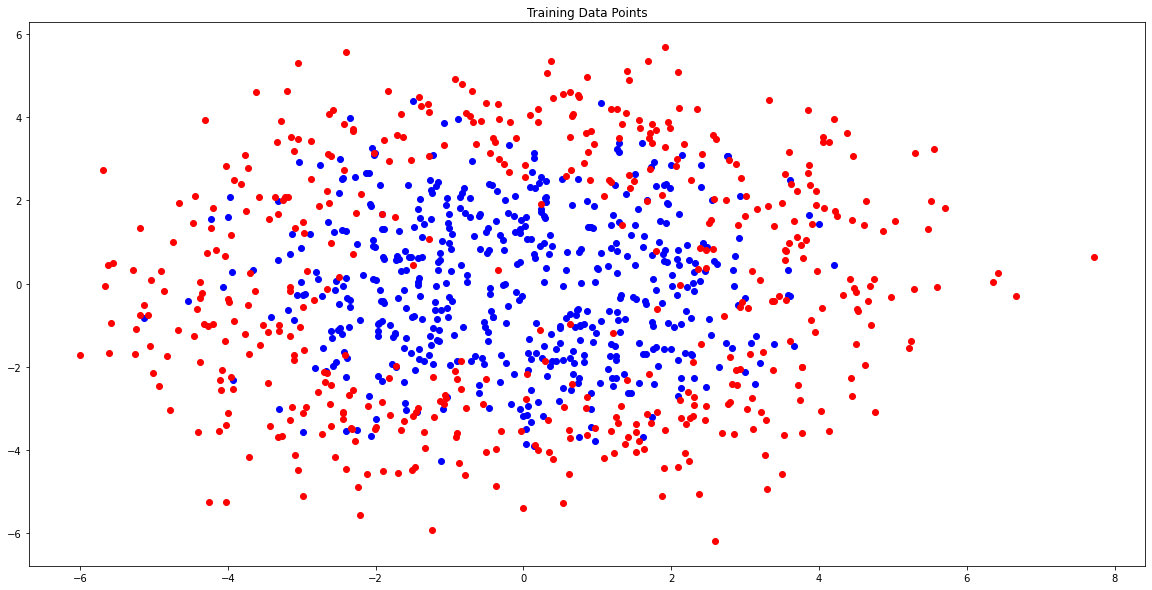

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Training Data Points")
ax.plot(X_train[y_train==-1, 0], X_train[y_train==-1, 1], 'bo')
ax.plot(X_train[y_train==1, 0], X_train[y_train==1, 1], 'ro')
plt.show()

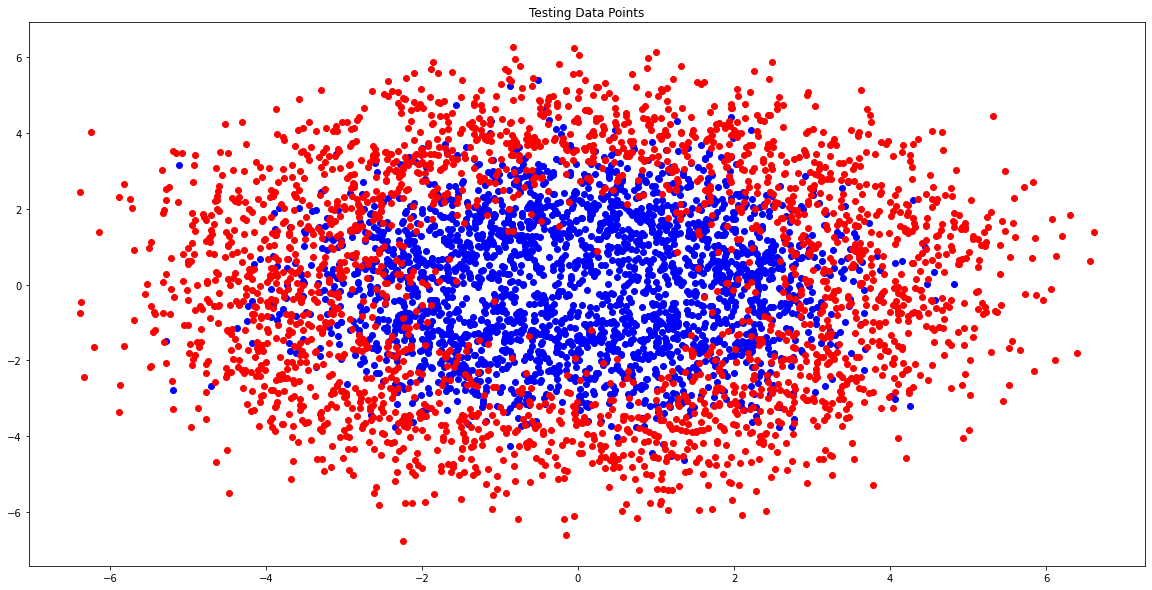

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Testing Data Points")
ax.plot(X_test[y_test==-1, 0], X_test[y_test==-1, 1], 'bo')
ax.plot(X_test[y_test==1, 0], X_test[y_test==1, 1], 'ro')
plt.show()

Best Regularization Strength: 10.000
Best Kernel Width: 0.010
SVM CV Probability of Error: 0.174


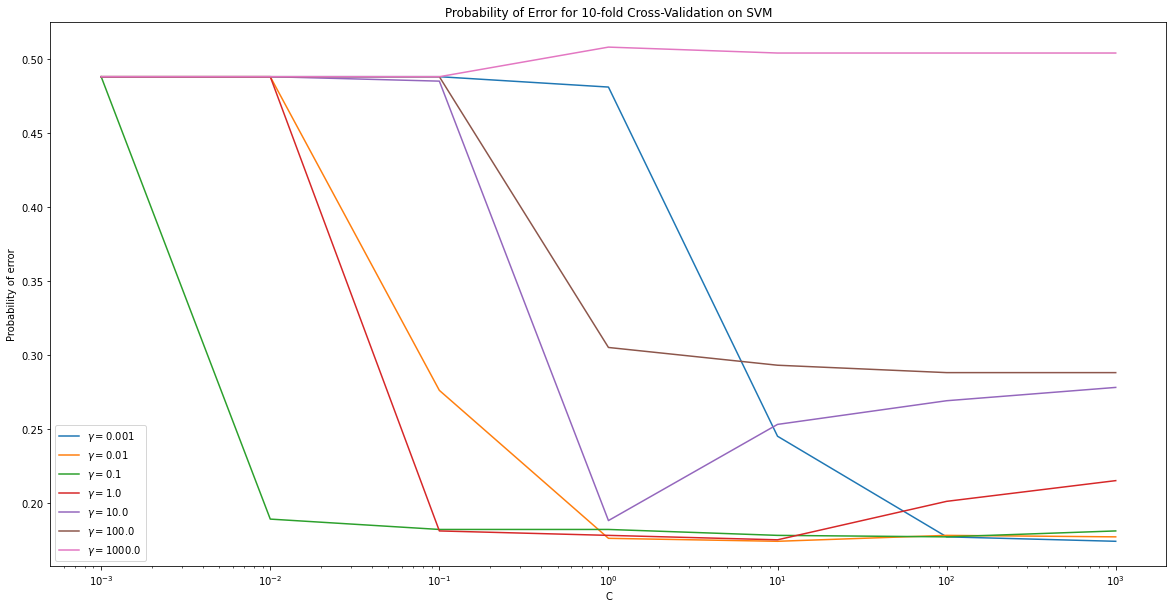

In [ ]:
K = 10
C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-3, 3, 7)
param_grid = {'C': C_range, 'gamma': gamma_range}
svc = SVC(kernel='rbf')
cv = KFold(n_splits=K, shuffle=True)
classifier = GridSearchCV(estimator=svc, param_grid=param_grid, cv=cv)
classifier.fit(X_train, y_train)
C_best = classifier.best_params_['C']
gamma_best = classifier.best_params_['gamma']
print("Best Regularization Strength: %.3f" % C_best)
print("Best Kernel Width: %.3f" % gamma_best)
print("SVM CV Probability of Error: %.3f" % (1-classifier.best_score_))
C_data = classifier.cv_results_['param_C'].data
gamma_data = classifier.cv_results_['param_gamma'].data
cv_prob_error = 1 - classifier.cv_results_['mean_test_score']
plt.figure(figsize=(20, 10))
for g in gamma_range:
    C = C_data[gamma_data == g]
    sort_idx = C.argsort()[::-1]
    prob_error = cv_prob_error[gamma_data == g]
    plt.plot(C[sort_idx], prob_error[sort_idx], label=fr"$\gamma = {g}$")
plt.title("Probability of Error for 10-fold Cross-Validation on SVM")
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Probability of error")
plt.legend()
plt.show()

SVM Probability of Error on the test data set: 0.1634



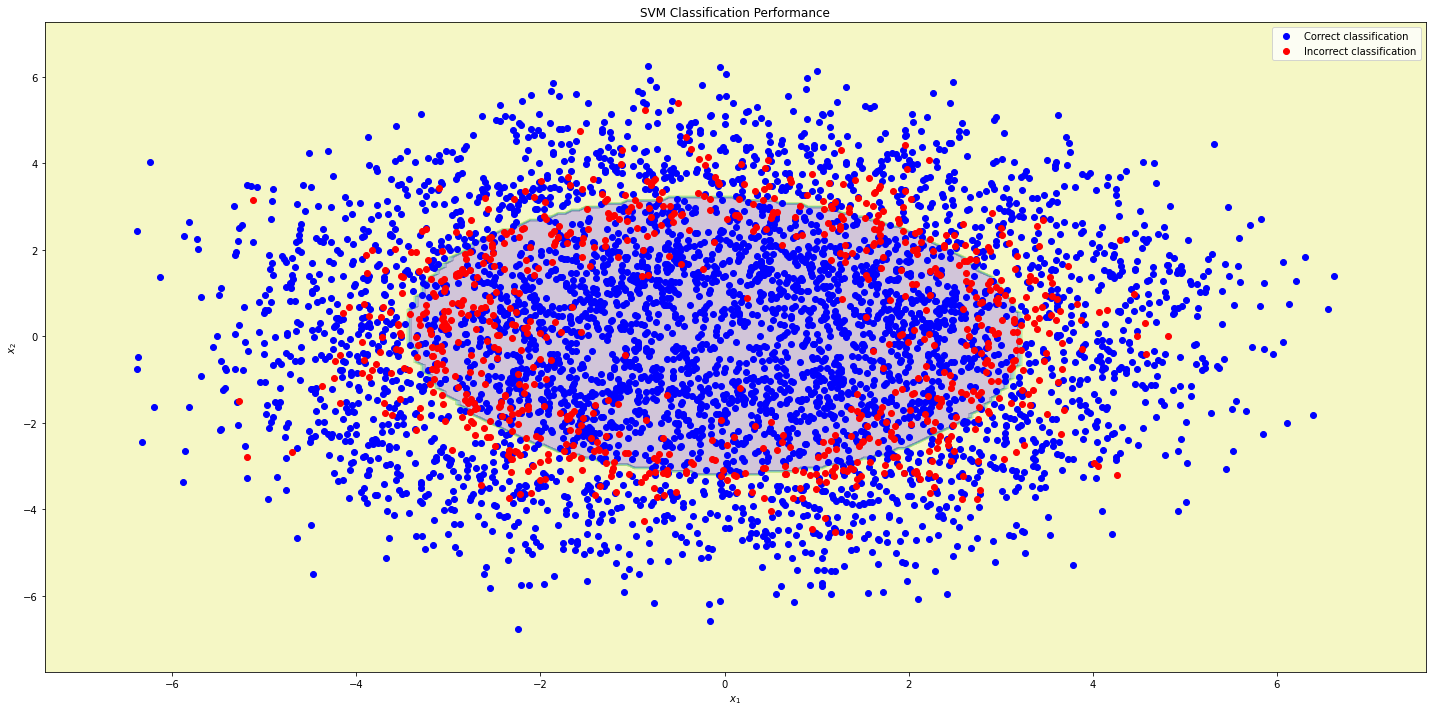

In [ ]:
classifier = SVC(C=C_best, kernel='rbf', gamma=gamma_best)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
incorrect_ind = np.argwhere(y_test != predictions)
prob_error_test = len(incorrect_ind) / N_test
print("SVM Probability of Error on the test data set: %.4f\n" % prob_error_test)
fig, ax = plt.subplots(figsize=(20, 10));
tn = np.argwhere((predictions == -1) & (y_test == -1))
fp = np.argwhere((predictions == 1) & (y_test == -1))
fn = np.argwhere((predictions == -1) & (y_test == 1))
tp = np.argwhere((predictions == 1) & (y_test == 1))
correct_0 = np.append(X_test[tn, 0], X_test[tp, 0])
correct_1 = np.append(X_test[tn, 1], X_test[tp, 1])
incorrect_0 = np.append(X_test[fp, 0], X_test[fn, 0])
incorrect_1 = np.append(X_test[fp, 1], X_test[fn, 1])
ax.plot(correct_0, correct_1, 'bo', label="Correct classification");
ax.plot(incorrect_0, incorrect_1, 'ro', label="Incorrect classification");
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
x_span = np.linspace(x_min, x_max, num=200)
y_span = np.linspace(y_min, y_max, num=200)
xx, yy = np.meshgrid(x_span, y_span)
grid = np.c_[xx.ravel(), yy.ravel()]
Z = classifier.predict(grid).reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.25)
ax.set_xlabel(r"$x_1$");
ax.set_ylabel(r"$x_2$");
ax.set_title("SVM Classification Performance")
plt.legend();
plt.tight_layout();
plt.show()

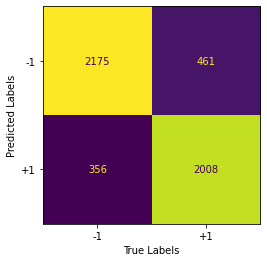

In [ ]:
conf_mat = confusion_matrix(predictions, y_test)
conf_display = ConfusionMatrixDisplay.from_predictions(predictions, y_test, display_labels=['-1', '+1'], colorbar=False);
plt.ylabel("Predicted Labels");
plt.xlabel("True Labels");

# Multi-layer Perceptron (MLP) Classifier

In [ ]:
loss_list = []
accuracy_list = []
class TwoLayerMLP(nn.Module):
    def __init__(self, in_dim, P, out_dim=1):
        super(TwoLayerMLP, self).__init__()
        self.input_fc = nn.Linear(in_dim, P)
        self.output_fc = nn.Linear(P, out_dim)
    def forward(self, X):
        X = self.input_fc(X)
        X = F.relu(X)
        return self.output_fc(X)
def model_train(model, data, labels, optimizer, criterion=nn.BCEWithLogitsLoss(), num_epochs=200):
    model.train()
    loss_sublist = []
    accuracy_sublist = []
    for epoch in range(num_epochs):
        outputs = model(data)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss_sublist.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        output = (outputs>0.5).float()
        correct = (output == labels.unsqueeze(1)).float().sum()
        accuracy_sublist.append(correct/output.shape[0])
    loss_list.append(loss_sublist)
    accuracy_list.append(accuracy_sublist)
    return model, loss
def model_predict(model, data):
    model.eval()
    with torch.no_grad():
        predicted_logits = model(data)
        predicted_probs = torch.sigmoid(predicted_logits).detach().numpy()
        return predicted_probs.reshape(-1)
def k_fold_cv_perceptrons(K, P_list, data, labels):
    kf = KFold(n_splits=K, shuffle=True) 
    error_valid_mk = np.zeros((len(P_list), K)) 
    m = 0
    for P in P_list:
        k = 0
        for train_indices, valid_indices in kf.split(data):
            X_train_k = torch.FloatTensor(data[train_indices])
            y_train_k = torch.FloatTensor(labels[train_indices])
            model = TwoLayerMLP(X_train_k.shape[1], P)
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            model, _ = model_train(model, X_train_k, y_train_k, optimizer)
            X_valid_k = torch.FloatTensor(data[valid_indices])
            y_valid_k = labels[valid_indices]
            prediction_probs = model_predict(model, X_valid_k)
            predictions = np.round(prediction_probs)
            error_valid_mk[m, k] = np.sum(predictions != y_valid_k) / len(y_valid_k)
            k += 1
        m += 1
    error_valid_m = np.mean(error_valid_mk, axis=1) 
    optimal_P = P_list[np.argmin(error_valid_m)]
    print("Optimum number of Perceptrons: %d" % optimal_P)
    print("Probability of Error: %.3f" % np.min(error_valid_m))
    fig = plt.figure(figsize=(20, 10))
    a = [1 - x for x in error_valid_m]
    plt.plot(P_list, a)
    plt.title("Cross-Validation results: MLP")
    plt.xlabel("Number of Hidden Units")
    plt.ylabel("Accuracy")
    plt.show()
    return optimal_P

Optimum number of Perceptrons: 32
Probability of Error: 0.173


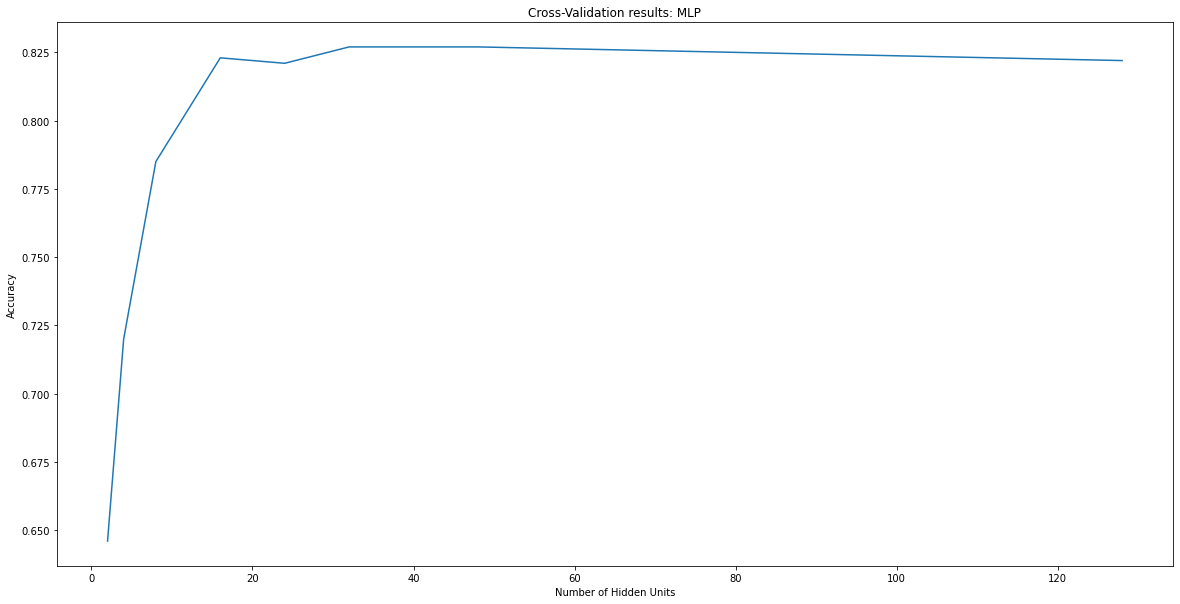

In [ ]:
P_list = [2, 4, 8, 16, 24, 32, 48, 64, 128]
lb = LabelBinarizer()
y_train_binary = lb.fit_transform(y_train)[:, 0]
P_best = k_fold_cv_perceptrons(K, P_list, X_train, y_train_binary)

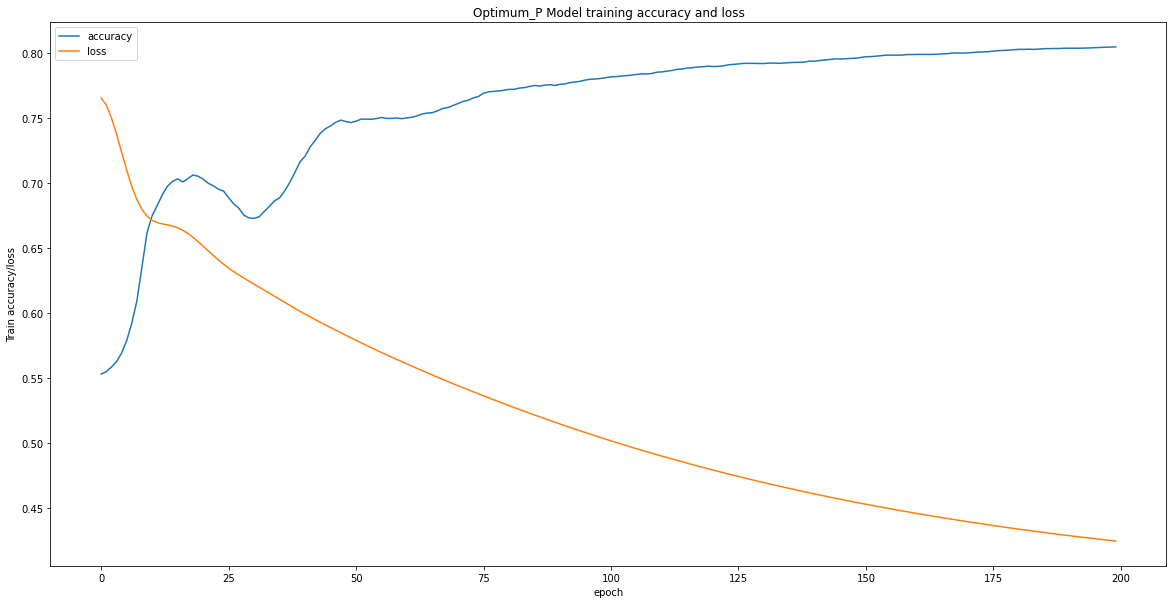

In [ ]:
x = P_list.index(P_best)*10
final_loss = []
final_accuracy = []
for i in range(200):
  temp_loss = 0
  temp_accuracy = 0
  for j in range(x, x+10):
    temp_loss = temp_loss + loss_list[j][i]
    temp_accuracy = temp_accuracy + accuracy_list[j][i]
  final_loss.append(temp_loss/10)
  final_accuracy.append(temp_accuracy/10)
xaxis = [i for i in range(200)]
plt.figure(figsize=(20, 10))
plt.title("Optimum_P Model training accuracy and loss")
plt.plot(xaxis, final_accuracy, label='accuracy')
plt.plot(xaxis, final_loss, label='loss')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Train accuracy/loss")
plt.show()

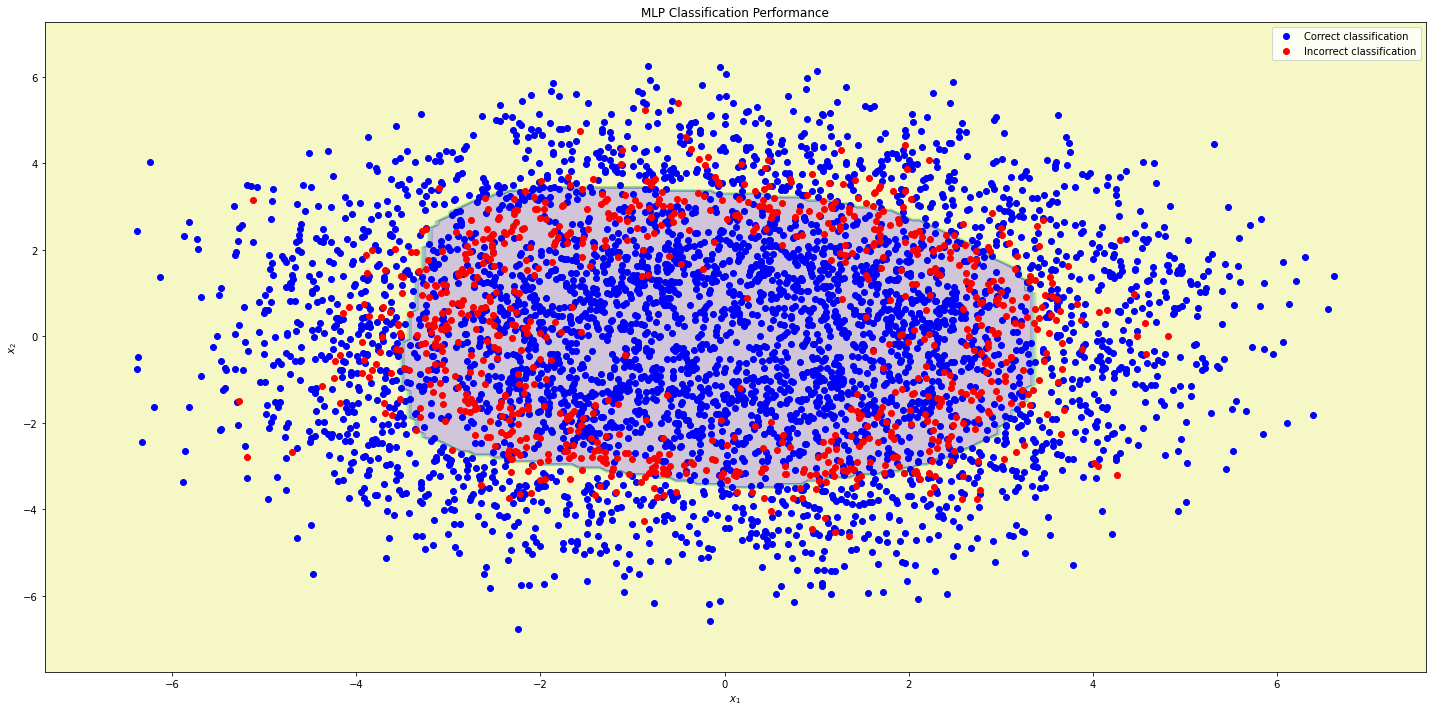

In [ ]:
num_restarts = 10
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train_binary)
restart_mlps = []
restart_losses = []
for r in range(num_restarts):
    model = TwoLayerMLP(X_train.shape[1], P_best)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    model, loss = model_train(model, X_train_tensor, y_train_tensor, optimizer)
    restart_mlps.append(model)
    restart_losses.append(loss.detach().item())
best_mlp = restart_mlps[np.argmin(restart_losses)]
X_test_tensor = torch.FloatTensor(X_test)
prediction_probs = model_predict(best_mlp, X_test_tensor)
predictions = np.round(prediction_probs)
predictions = lb.inverse_transform(predictions)
incorrect_ind = np.argwhere(y_test != predictions)
prob_error_test = len(incorrect_ind) / N_test
fig, ax = plt.subplots(figsize=(20, 10));
tn = np.argwhere((predictions == -1) & (y_test == -1))
fp = np.argwhere((predictions == 1) & (y_test == -1))
fn = np.argwhere((predictions == -1) & (y_test == 1))
tp = np.argwhere((predictions == 1) & (y_test == 1))
correct_0 = np.append(X_test[tn, 0], X_test[tp, 0])
correct_1 = np.append(X_test[tn, 1], X_test[tp, 1])
incorrect_0 = np.append(X_test[fp, 0], X_test[fn, 0])
incorrect_1 = np.append(X_test[fp, 1], X_test[fn, 1])
ax.plot(correct_0, correct_1, 'bo', label="Correct classification");
ax.plot(incorrect_0, incorrect_1, 'ro', label="Incorrect classification");
grid_tensor = torch.FloatTensor(grid)
best_mlp.eval()
Z = best_mlp(grid_tensor).detach().numpy()
Z = lb.inverse_transform(np.round(Z)).reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.25)
ax.set_xlabel(r"$x_1$");
ax.set_ylabel(r"$x_2$");
ax.set_title("MLP Classification Performance")
plt.legend();
plt.tight_layout();
plt.show()

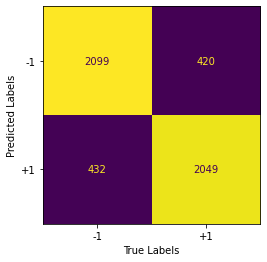

In [ ]:
conf_mat = confusion_matrix(predictions, y_test)
conf_display = ConfusionMatrixDisplay.from_predictions(predictions, y_test, display_labels=['-1', '+1'], colorbar=False);
plt.ylabel("Predicted Labels");
plt.xlabel("True Labels");